In [1]:
#install pytorch if you do not have installed
!pip install torch torchsummaryX --quiet

# import time to visualize the total training time 
from time import time

# install libraries for computation of model: NumPy, Pandas, PyTorch, TorchsummaryX, Scikitlearn 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummaryX import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score

# install libraries for utilities: gc, tqdm, os, datetime 
import gc
from tqdm.auto import tqdm
import os
import sys
import datetime
import matplotlib.pyplot as plt

#install confusion matrix for comparison to grand truth
from sklearn import metrics

# install ETL
%cd /content/drive/MyDrive/Colab Notebooks/ECT/
from cervical_cancer import CervicalCancer
%cd /content/

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

/content/drive/MyDrive/Colab Notebooks/ECT
/content
Device:  cpu


In [3]:
# install and import skater and skater.core.explanations.Interpretation 
!pip install git+https://github.com/oracle/Skater.git
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/oracle/Skater.git to /tmp/pip-req-build-sqvl5ah0
  Running command git clone -q https://github.com/oracle/Skater.git /tmp/pip-req-build-sqvl5ah0
     |████████████████████████████████| 275 kB 4.0 MB/s 
     |████████████████████████████████| 132 kB 57.1 MB/s 
  Created wheel for skater: filename=skater-1.1.2b1-py3-none-any.whl size=4637020 sha256=033e10ff4aa2cf6021c07be5ecb4c7492e2bebb52084063da91dc97bb383e1ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-j1w7rt6q/wheels/88/fb/54/c5a75c31373e0c38ba379e3ebd04dde7024e706333480e03a2
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=3e2f1f8a9133653464a0c500defa4d25e059ffd0e3a8e6554624cd8c5b4c6276
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built skater lime


In [4]:
class BinaryBalancedSampler(DataLoader):
    def __init__(self, dataset, n_samples=50, balance = False, verbose=False, shuffle=False):
        self.dataset = dataset
        self.balance = balance

        # separate dataset as inputs and targets
        self.inputs = self.dataset[:, :-1]
        self.targets = self.dataset[:, -1].astype(np.int64)
        assert self.inputs.shape[0] == self.targets.shape[0]

        #inbalanced data identification
        target_counts = np.bincount(self.targets)
        major_target = target_counts.argmax()
        minor_target = target_counts.argmin()
        self.major_indices = np.where(self.targets == major_target)[0]
        self.minor_indices = np.where(self.targets == minor_target)[0]

        # shuffle
        if shuffle:
            np.random.shuffle(self.major_indices)
            np.random.shuffle(self.minor_indices)

        # convert data as float
        for i in range(self.inputs.shape[1]):
            self.inputs[:, i] = self.inputs[:, i].astype(np.float32)
        #for i in range(self.inputs.shape[1]):
        #    print(f"self.inputs[0, i].dtype {type(self.inputs[0, i])}")

        # Set length of the dataset: 
        self.length = self.inputs.shape[0]

        # Debug:
        if verbose:
            print(f"self.inputs {self.inputs.shape}")
            print(f"self.targets {self.targets.shape}")
            print(f"self.length {self.length}")

        self.used_indices = 0
        self.count = 0
        self.n_samples = n_samples
        #self.batch_size = self.n_samples * 2

        self.length = self.dataset.shape[0]

    def __len__(self):
      return self.length

    def __iter__(self):
        self.count = 0
        self.used_indices = int(0)
        if self.balance:
            while self.used_indices < len(self.major_indices):
                indices = self.major_indices[self.used_indices:self.used_indices + self.n_samples].tolist()
                indices += np.random.choice(self.minor_indices, self.n_samples, replace=True).tolist()
                inputs_tensor = torch.tensor(self.inputs[indices].astype(np.float32))
                targets_tensor = torch.tensor(self.targets[indices].astype(np.int64))
                yield inputs_tensor, targets_tensor
                
                self.used_indices += self.n_samples
                self.count += self.n_samples * 2
        else:
            while self.used_indices < self.targets.shape[0]:
                inputs_tensor = torch.tensor(self.inputs[self.used_indices: self.used_indices + self.n_samples].astype(np.float32))
                targets_tensor = torch.tensor(self.targets[self.used_indices: self.used_indices + self.n_samples].astype(np.int64))
                
                yield inputs_tensor, targets_tensor
                
                self.used_indices += self.n_samples
                self.count += self.n_samples * 2

# Debug
#cc_array = CervicalCancer(data_path='/content/', file='risk_factors_cervical_cancer.csv', mode='array')
#test_iter = BinaryBalancedSampler(cc_array.dataset, n_samples=40, balance=False)
#for i in test_iter:
#    inputs, targets = i
#    print(inputs.shape)
#    print(targets.shape)
#    print(np.bincount(targets))
#    break

#if __name__ == '__main__':
#    cc_array = CervicalCancer(data_path='/content/', file='risk_factors_cervical_cancer.csv', mode='array')
#    dataset = Dataset(cc_array.dataset)

In [5]:
configs = {
    'train_dataset_ratio':0.8,
    'epochs': 30,
    'batch_size' : 32,
    'learning_rate' : 0.01,
    'weight_decay' : 0,
    'dropout_value' : 0.55,
    'T_max':30,
    'eta_min':0,
    'n_samples':10,
}

In [6]:
'''
Datea set loading: the dataset has following columns.
Enplanatory varibales
0:Age, 1:Number of sexual partners, 2:First sexual intercourse, 3:Num of pregnancies, 4:Smokes, 
5:Smokes (years), 6:Smokes (packs/year), 7:Hormonal Contraceptives, 8:Hormonal Contraceptives (years), 9:IUD, 
10:IUD (years), 11:STDs, 12:STDs (number), 13:STDs:condylomatosis, 14:STDs:cervical condylomatosis, 
15:STDs:vaginal condylomatosis, 16:STDs:vulvo-perineal condylomatosis, 17:STDs:syphilis, 18:STDs:pelvic inflammatory disease, 19:STDs:genital herpes, 
20:STDs:molluscum contagiosum, 21:STDs:AIDS, 22:STDs:HIV, 23:STDs:Hepatitis B, 24:STDs:HPV, 
25:STDs: Number of diagnosis, 26:STDs: Time since first diagnosis, 27:STDs: Time since last diagnosis, 28:Dx:Cancer, 29:Dx:CIN
30:Dx:HPV, 31:Dx

Target varibales
32:Hinselmann, 33:Schiller, 34:Citology, 35:Biopsy

'''
# load dataset
cc_df = CervicalCancer(data_path='/content/', file='risk_factors_cervical_cancer.csv', mode='dataframe')
#print(f"cc_df.dataset.shape {cc_df.dataset.shape}")
# shuffle data
indices = np.random.permutation(np.arange(cc_df.dataset.shape[0]))
shuffled_dataset = []

# insert shuffled dataset specified columns into shaffled_dataset
column_list = [0, 1, 2, 3, 5, 6, 8, 10, 12, 28, 29, 30, 31, 35]
for i in indices:
    shuffled_dataset.append(cc_df.dataset.iloc[i, column_list])

sd_column_headers = list(cc_df.dataset.columns.values[column_list])
shuffled_dataset = np.array(shuffled_dataset)
#print(f"sd_column_headers {sd_column_headers}")

# separate shuffled_dataset into train and test dataset
train_dataset_ratio = configs['train_dataset_ratio']
train_dataset_length = int(shuffled_dataset.shape[0] * train_dataset_ratio)
train_dataset = shuffled_dataset[:train_dataset_length].astype(np.float32)
test_dataset = shuffled_dataset[train_dataset_length:].astype(np.float32)

In [7]:
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
train_loader = BinaryBalancedSampler(train_dataset, n_samples=configs['n_samples'], balance=True, verbose=True, shuffle=True)
test_loader = BinaryBalancedSampler(test_dataset, balance=False, verbose=True)

self.inputs (686, 13)
self.targets (686,)
self.length 686
self.inputs (172, 13)
self.targets (172,)
self.length 172


In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            # first layer: lowest layer faeture values and activation
            nn.Linear(13, 256, device=device),
            nn.BatchNorm1d(256, device=device),
            nn.ReLU(inplace=True),
            nn.Dropout(configs['dropout_value']),

            # hidden layer 1: hidden faeture values
            nn.Linear(256, 128, device=device),
            nn.BatchNorm1d(128, device=device),
            nn.ReLU(inplace=True),
            nn.Dropout(configs['dropout_value']),

            # hidden layer 2: hidden faeture values
            nn.Linear(128, 64, device=device),
            nn.BatchNorm1d(64, device=device),
            nn.ReLU(inplace=True),

            # output layer: classification result
            nn.Linear(64, 2, device=device),
        )
        
        # initialization the model weights and model bias
        self.apply(self._init_weights)
       
    def forward(self, x):
        x = x.to(device)
        output = self.model(x).to(device)
        #print(f"output {output.shape} {output.dtype} {output}")
        return output

    # Weight and Bias initialization: Kaiming/Xavier
    # Code from Pytorch (https://pytorch.org/docs/stable/nn.init.html)
    # Code from WandB (https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')


In [9]:
class Trainer():
    def __init__(self, model, optimizer, criterion, scheduler, dataloader, mode='Train'):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.dataloader = dataloader
        self.mode = mode

    def train(self):
        if self.mode == 'Train':
            self.model.train()
        elif self.mode == 'Eval':
            self.model.eval()

        train_loss = 0.0 # Monitoring Loss
        print(f"train_loss {train_loss}")
        for iter, (inputs, targets) in enumerate(self.dataloader):
            num_batch = iter
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Loss Calculation
            with torch.cuda.amp.autocast():
                # Forward Propagation
                logits = self.model(inputs)
                #print(f"logits {logits}")
                loss = self.compute_loss(logits, targets)
                train_loss += loss.item()

                ### Initialize Gradients
                self.optimizer.zero_grad()
                ### Backward Propagation
                loss.backward()
                ### Gradient Descent
                self.optimizer.step()

            ### Schedule update
            self.scheduler.step()

        train_loss /= num_batch
        return train_loss

    def compute_loss(self, logits, targets):
        loss = self.criterion(logits, targets)
        return loss

    def compute_accuacies(self):
        # Calculate indicators: Accuracy, Precision, Recall, Specificity
        accuracy = accuracy_score(self.prediction_list, self.true_list) * 100
        precision = precision_score(self.prediction_list, self.true_list) * 100
        recall = recall_score(self.prediction_list, self.true_list) * 100

        return accuracy, precision, recall

    def predict(self, dataset):
        # initialize result lists and loss value
        self.prediction_logit_list = []
        self.prediction_list = []
        self.true_list = []        
        
        loader = BinaryBalancedSampler(dataset, balance=False)

        #with torch.no_grad():
        for iter, (inputs, targets) in enumerate(loader):
            num_batch = iter
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Loss Calculation
            with torch.cuda.amp.autocast():
                # Forward Propagation
                logits = self.model(inputs)
                prediction = torch.argmax(logits, dim=1)

            ### Store Pred and True Labels
            self.prediction_logit_list.extend(np.array(logits.cpu().tolist()))
            self.prediction_list.extend(np.array(prediction.cpu().tolist()))
            self.true_list.extend(np.array(targets.cpu().tolist()))
        
        #del frames, phonemes, logits, loss
        torch.cuda.empty_cache()

    def predict_prob(self, *args, **kwargs):
        return pd.DataFrame(self.prediction_logit_list)

    def predict_label(self, *args, **kwargs):
        return pd.DataFrame(self.prediction_list)

    def true_label(self, *args, **kwargs):
        return pd.DataFrame(self.true_list)

In [10]:
# If you execute model for the first time, use this command
model = NeuralNetwork().to(device)

# Criterion, Optimizer and Scheduler
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=configs['learning_rate'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=configs['T_max'], eta_min=configs['eta_min'])

# Debug
inputs, targets = next(iter(train_loader))
summary(model, inputs)

  df_sum = df.sum()



                      Kernel Shape Output Shape   Params Mult-Adds
Layer                                                             
0_model.Linear_0         [13, 256]    [20, 256]   3.584k    3.328k
1_model.BatchNorm1d_1        [256]    [20, 256]    512.0     256.0
2_model.ReLU_2                   -    [20, 256]        -         -
3_model.Dropout_3                -    [20, 256]        -         -
4_model.Linear_4        [256, 128]    [20, 128]  32.896k   32.768k
5_model.BatchNorm1d_5        [128]    [20, 128]    256.0     128.0
6_model.ReLU_6                   -    [20, 128]        -         -
7_model.Dropout_7                -    [20, 128]        -         -
8_model.Linear_8         [128, 64]     [20, 64]   8.256k    8.192k
9_model.BatchNorm1d_9         [64]     [20, 64]    128.0      64.0
10_model.ReLU_10                 -     [20, 64]        -         -
11_model.Linear_11         [64, 2]      [20, 2]    130.0     128.0
--------------------------------------------------------------

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Linear_0,"[13, 256]","[20, 256]",3584.0,3328.0
1_model.BatchNorm1d_1,[256],"[20, 256]",512.0,256.0
2_model.ReLU_2,-,"[20, 256]",NaN,NaN
3_model.Dropout_3,-,"[20, 256]",NaN,NaN
4_model.Linear_4,"[256, 128]","[20, 128]",32896.0,32768.0
5_model.BatchNorm1d_5,[128],"[20, 128]",256.0,128.0
6_model.ReLU_6,-,"[20, 128]",NaN,NaN
7_model.Dropout_7,-,"[20, 128]",NaN,NaN
8_model.Linear_8,"[128, 64]","[20, 64]",8256.0,8192.0


In [11]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()

best_acc = 0.0 ### Monitor best accuracy in your run
start = time()

trainer = Trainer(model, optimizer, criterion, scheduler, train_loader)

for epoch in range(configs['epochs']):
    print("\nEpoch {}/{}".format(epoch+1, configs['epochs']))
    train_loss = trainer.train()
    trainer.predict(train_dataset)
    train_true_array = trainer.true_label()
    train_prediction_array = trainer.predict_label()
    train_accuracy, train_precision, train_recall  = trainer.compute_accuacies()

    print("\tTrain Loss: {:.4f}".format(train_loss))
    print("\tValidation Accuracy: {:.2f}%".format(train_accuracy))
    print("\tValidation Precision: {:.2f}%".format(train_precision))
    print("\tValidation Recall: {:.2f}%".format(train_recall))

#print(f"\tprediction_list {train_prediction_array}")
#print(f"\ttrue_list \t{train_true_array}")

  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')




Epoch 1/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 1.9210
	Validation Accuracy: 42.42%
	Validation Precision: 76.74%
	Validation Recall: 7.89%

Epoch 2/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 1.3012
	Validation Accuracy: 44.61%
	Validation Precision: 69.77%
	Validation Recall: 7.56%

Epoch 3/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.9718
	Validation Accuracy: 56.56%
	Validation Precision: 53.49%
	Validation Recall: 7.64%

Epoch 4/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.8949
	Validation Accuracy: 54.37%
	Validation Precision: 67.44%
	Validation Recall: 8.84%

Epoch 5/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.8076
	Validation Accuracy: 48.25%
	Validation Precision: 72.09%
	Validation Recall: 8.29%

Epoch 6/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.7527
	Validation Accuracy: 57.00%
	Validation Precision: 72.09%
	Validation Recall: 9.87%

Epoch 7/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.7291
	Validation Accuracy: 56.12%
	Validation Precision: 69.77%
	Validation Recall: 9.43%

Epoch 8/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6914
	Validation Accuracy: 50.73%
	Validation Precision: 74.42%
	Validation Recall: 8.91%

Epoch 9/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6588
	Validation Accuracy: 49.13%
	Validation Precision: 79.07%
	Validation Recall: 9.09%

Epoch 10/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6487
	Validation Accuracy: 53.64%
	Validation Precision: 76.74%
	Validation Recall: 9.68%

Epoch 11/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6608
	Validation Accuracy: 49.71%
	Validation Precision: 86.05%
	Validation Recall: 9.84%

Epoch 12/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6249
	Validation Accuracy: 47.52%
	Validation Precision: 76.74%
	Validation Recall: 8.62%

Epoch 13/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6186
	Validation Accuracy: 48.83%
	Validation Precision: 81.40%
	Validation Recall: 9.26%

Epoch 14/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6282
	Validation Accuracy: 41.40%
	Validation Precision: 88.37%
	Validation Recall: 8.74%

Epoch 15/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6024
	Validation Accuracy: 44.17%
	Validation Precision: 86.05%
	Validation Recall: 8.94%

Epoch 16/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5927
	Validation Accuracy: 48.98%
	Validation Precision: 79.07%
	Validation Recall: 9.07%

Epoch 17/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6081
	Validation Accuracy: 52.04%
	Validation Precision: 83.72%
	Validation Recall: 10.06%

Epoch 18/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5925
	Validation Accuracy: 62.83%
	Validation Precision: 76.74%
	Validation Recall: 11.87%

Epoch 19/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.6097
	Validation Accuracy: 55.83%
	Validation Precision: 81.40%
	Validation Recall: 10.61%

Epoch 20/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5778
	Validation Accuracy: 55.54%
	Validation Precision: 90.70%
	Validation Recall: 11.47%

Epoch 21/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5903
	Validation Accuracy: 54.81%
	Validation Precision: 88.37%
	Validation Recall: 11.08%

Epoch 22/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5895
	Validation Accuracy: 53.79%
	Validation Precision: 86.05%
	Validation Recall: 10.63%

Epoch 23/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5823
	Validation Accuracy: 52.04%
	Validation Precision: 83.72%
	Validation Recall: 10.06%

Epoch 24/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5583
	Validation Accuracy: 52.04%
	Validation Precision: 93.02%
	Validation Recall: 10.93%

Epoch 25/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5745
	Validation Accuracy: 49.27%
	Validation Precision: 88.37%
	Validation Recall: 9.97%

Epoch 26/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5608
	Validation Accuracy: 53.50%
	Validation Precision: 88.37%
	Validation Recall: 10.80%

Epoch 27/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5812
	Validation Accuracy: 51.90%
	Validation Precision: 88.37%
	Validation Recall: 10.47%

Epoch 28/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5252
	Validation Accuracy: 55.98%
	Validation Precision: 90.70%
	Validation Recall: 11.57%

Epoch 29/30
train_loss 0.0


  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Train Loss: 0.5629
	Validation Accuracy: 50.73%
	Validation Precision: 90.70%
	Validation Recall: 10.46%

Epoch 30/30
train_loss 0.0
	Train Loss: 0.5123
	Validation Accuracy: 56.71%
	Validation Precision: 86.05%
	Validation Recall: 11.28%


In [12]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()

print("\nEpoch {}/{}".format(epoch+1, configs['epochs']))
trainer.predict(test_dataset)
test_true_array = trainer.true_label()
test_prediction_array = trainer.predict_label()
test_accuracy, test_precision, test_recall  = trainer.compute_accuacies()

print("\tTest Accuracy: {:.2f}%".format(test_accuracy))
print("\tTest Precision: {:.2f}%".format(test_precision))
print("\tTest Recall: {:.2f}%".format(test_recall))

#print(f"\tprediction_list {test_prediction_array}")
#print(f"\ttrue_list \t{test_true_array}")

  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')




Epoch 30/30
	Test Accuracy: 61.05%
	Test Precision: 83.33%
	Test Recall: 13.33%


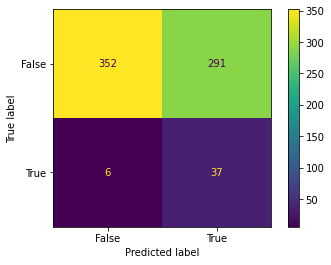

In [13]:
# Build confusion matrix
conf_matrix = metrics.confusion_matrix(train_true_array, train_prediction_array)
df_conf_matrix = pd.DataFrame(conf_matrix/np.sum(conf_matrix) *10, index = [1, 0], columns = [1, 0])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()

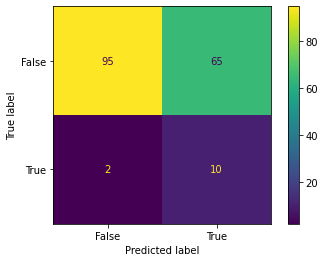

In [14]:
# Build confusion matrix
conf_matrix = metrics.confusion_matrix(test_true_array, test_prediction_array)
df_conf_matrix = pd.DataFrame(conf_matrix/np.sum(conf_matrix) *10, index = [1, 0], columns = [1, 0])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()

In [24]:
# leveraging skater for feature importances
train_dataset[train_dataset == 0] = 0.000000001
test_dataset[test_dataset == 0] = 0.000000001

interpreter = Interpretation(test_dataset, feature_names=sd_column_headers)
im_model = InMemoryModel(trainer.predict_prob, examples=train_dataset)

# plot the feature importance plots
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending = False)

2022-12-01 05:17:14,933 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[14/14] features ████████████████████ Time elapsed: 1 seconds

FeatureImportanceError: ignored